# Training Modular U-Net Example Notebook

This notebook demonstrates how to train `virtual_stain_flow.models` module.
Uses a simplified train loop for Trainer agnostic exemplification.

## Dependencies

In [1]:
import yaml
import pathlib

import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Dataset
from virtual_stain_flow.datasets.PatchDataset import PatchDataset

## Normalization
from virtual_stain_flow.transforms.MinMaxNormalize import MinMaxNormalize

from virtual_stain_flow.models.unet import UNet

/home/weishanli/anaconda3/envs/cp_gan_viscy_env/lib/python3.9/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Retrieve Demo Data

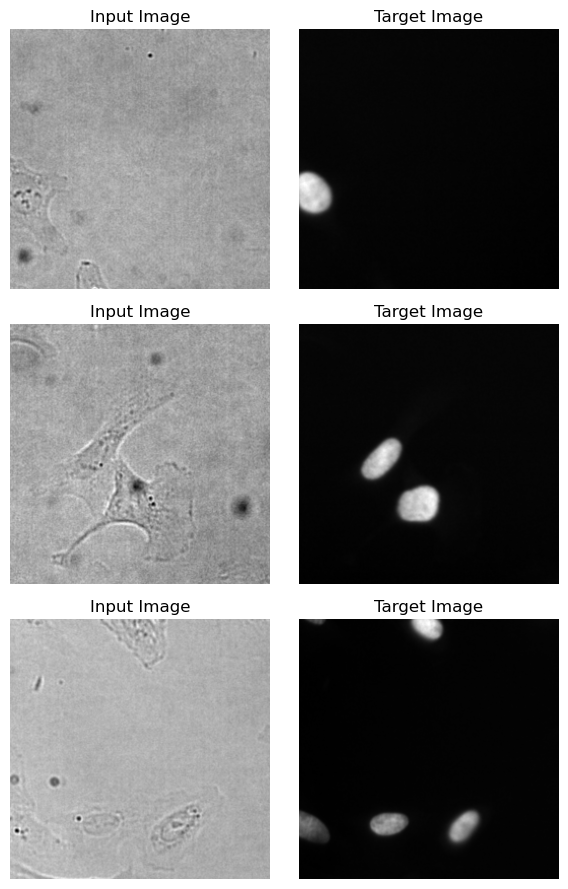

In [2]:
ANALYSIS_REPO_ROOT = pathlib.Path('.').absolute().parent.parent / 'pediatric_cancer_atlas_analysis'
CONFIG_PATH = ANALYSIS_REPO_ROOT / 'config.yml'
config = yaml.safe_load(CONFIG_PATH.read_text())

LOADDATA_FILE_PATH = ANALYSIS_REPO_ROOT / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_train.csv'
assert LOADDATA_FILE_PATH.exists(), f"File not found: {LOADDATA_FILE_PATH}" 

PROFILING_DIR = pathlib.Path(config['paths']['pediatric_cancer_atlas_profiling_path'])
assert PROFILING_DIR.exists(), f"Directory not found: {PROFILING_DIR}"

SC_FEATURES_DIR = pathlib.Path(config['paths']['sc_features_path'])
assert SC_FEATURES_DIR.exists(), f"Directory not found: {SC_FEATURES_DIR}"

# subset the loaddata_df to 10 samples for faster example run
loaddata_df = pd.read_csv(LOADDATA_FILE_PATH)
loaddata_df = loaddata_df.sample(n=10, random_state=42)

sc_features = pd.DataFrame()
for plate in loaddata_df['Metadata_Plate'].unique():
    sc_features_parquet = SC_FEATURES_DIR / f'{plate}_sc_normalized.parquet'
    if not sc_features_parquet.exists():
        print(f'{sc_features_parquet} does not exist, skipping...')
        continue 
    else:
        sc_features = pd.concat([
            sc_features, 
            pd.read_parquet(
                sc_features_parquet,
                columns=['Metadata_Plate', 'Metadata_Well', 'Metadata_Site', 'Metadata_Cells_Location_Center_X', 'Metadata_Cells_Location_Center_Y']
            )
        ])

INPUT_CHANNEL_NAMES = config['data']['input_channel_keys']
TARGET_CHANNEL_NAMES = config['data']['target_channel_keys']
TARGET_CHANNEL_NAMES = TARGET_CHANNEL_NAMES[0] if isinstance(TARGET_CHANNEL_NAMES, list) else TARGET_CHANNEL_NAMES
PATCH_SIZE = 256

pds = PatchDataset(
        _loaddata_csv=loaddata_df,
        _sc_feature=sc_features,
        _input_channel_keys=INPUT_CHANNEL_NAMES,
        _target_channel_keys=TARGET_CHANNEL_NAMES,
        _input_transform=MinMaxNormalize(
            _normalization_factor=(2 ** 16) - 1, _always_apply=True),
        _target_transform=MinMaxNormalize(
            _normalization_factor=(2 ** 16) - 1, _always_apply=True),
        patch_size=PATCH_SIZE,
        verbose=False,
        patch_generation_method="random_cell",
        n_expected_patches_per_img=50,
        patch_generation_random_seed=42
    )

panel_width = 3
indices = [3, 5, 7]
fig, ax = plt.subplots(len(indices), 2, figsize=(panel_width * 2, panel_width * len(indices)))

for i, j in enumerate(indices):
    input, target = pds[j]
    ax[i][0].imshow(input[0], cmap='gray')
    ax[i][0].set_title('Input Image')
    ax[i][0].axis('off')
    ax[i][1].imshow(target[0], cmap='gray')
    ax[i][1].set_title('Target Image')
    ax[i][1].axis('off')
plt.tight_layout()
plt.show()

## Trains just like any torch.nn.Module

Epoch [1/10], Loss: 0.160108


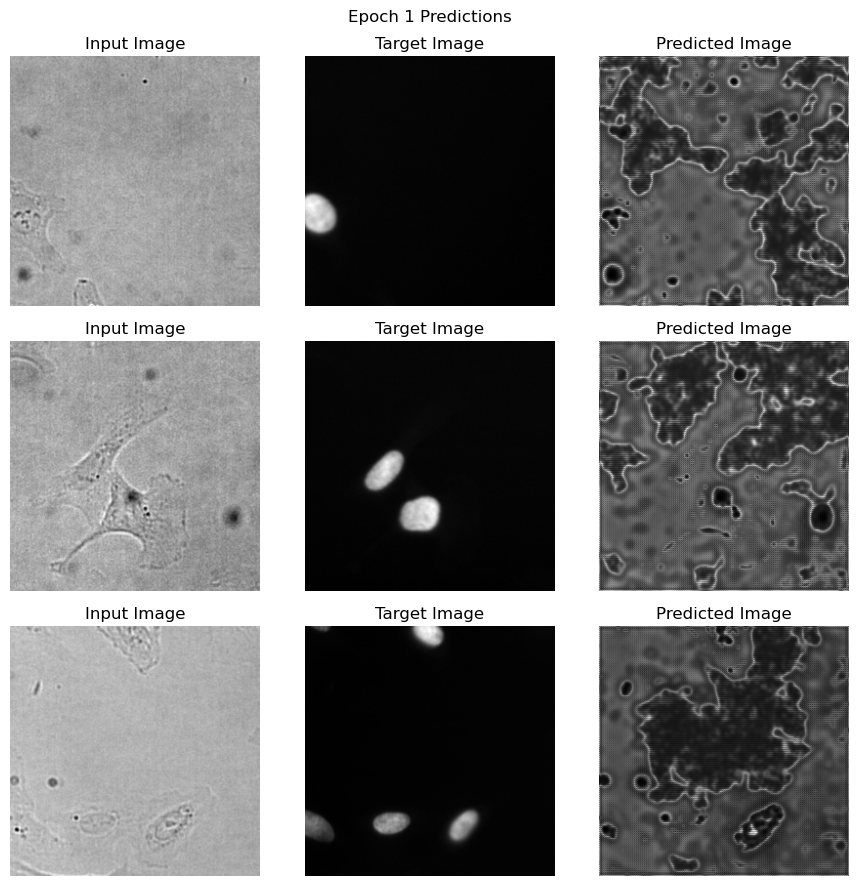

Epoch [2/10], Loss: 0.021912


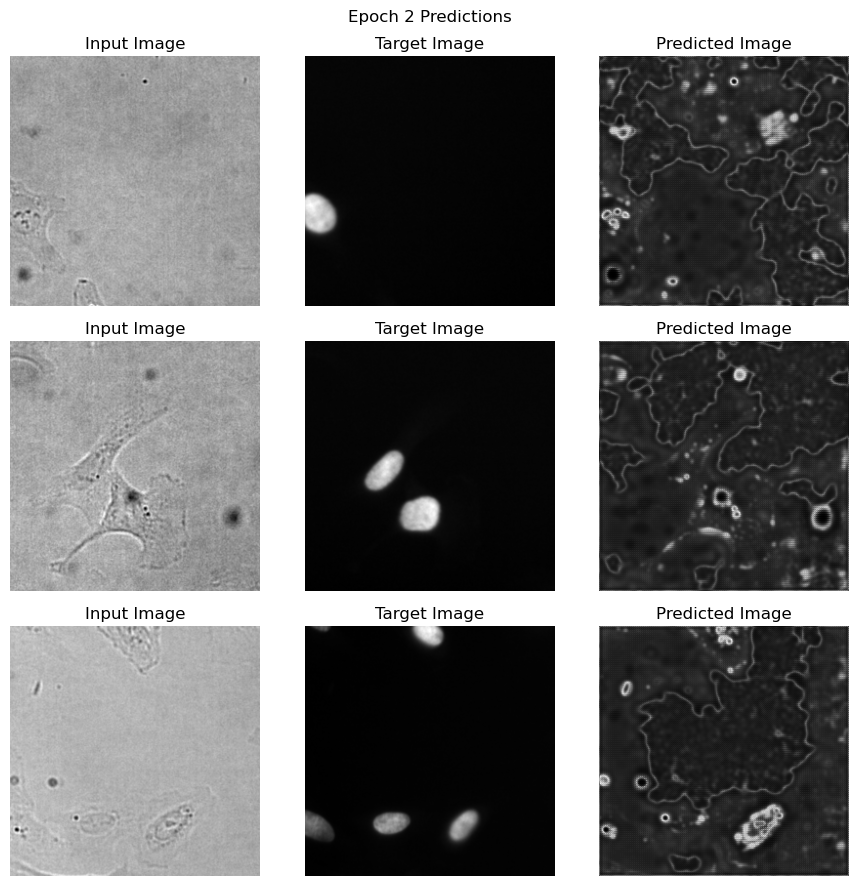

Epoch [3/10], Loss: 0.022687


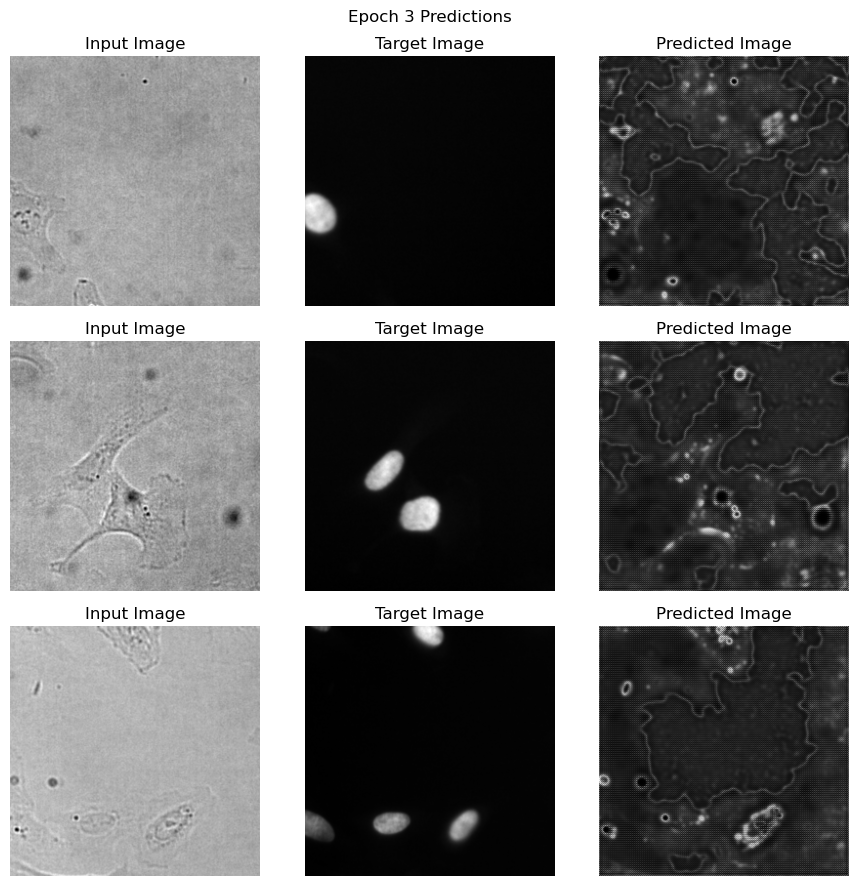

Epoch [4/10], Loss: 0.021813


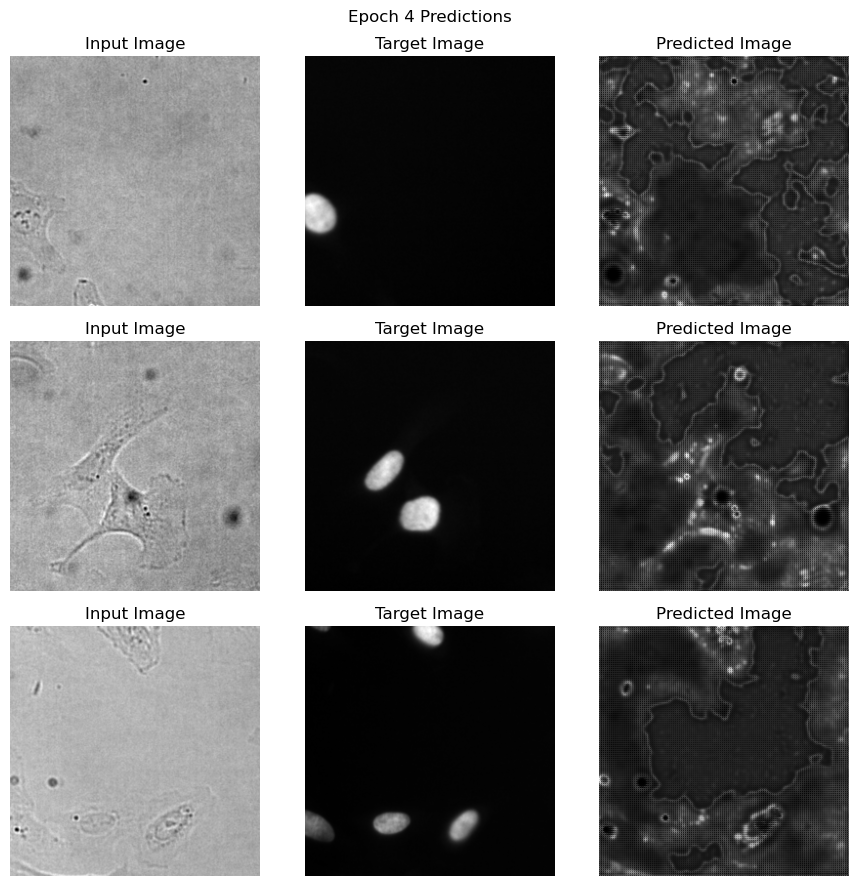

Epoch [5/10], Loss: 0.020817


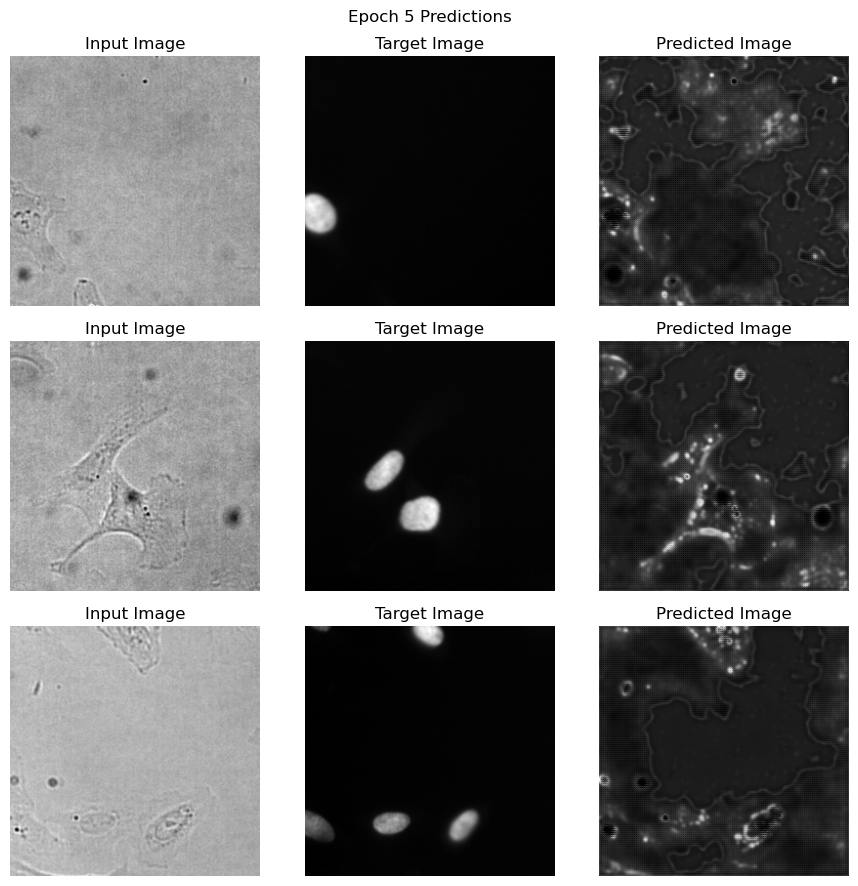

Epoch [6/10], Loss: 0.019762


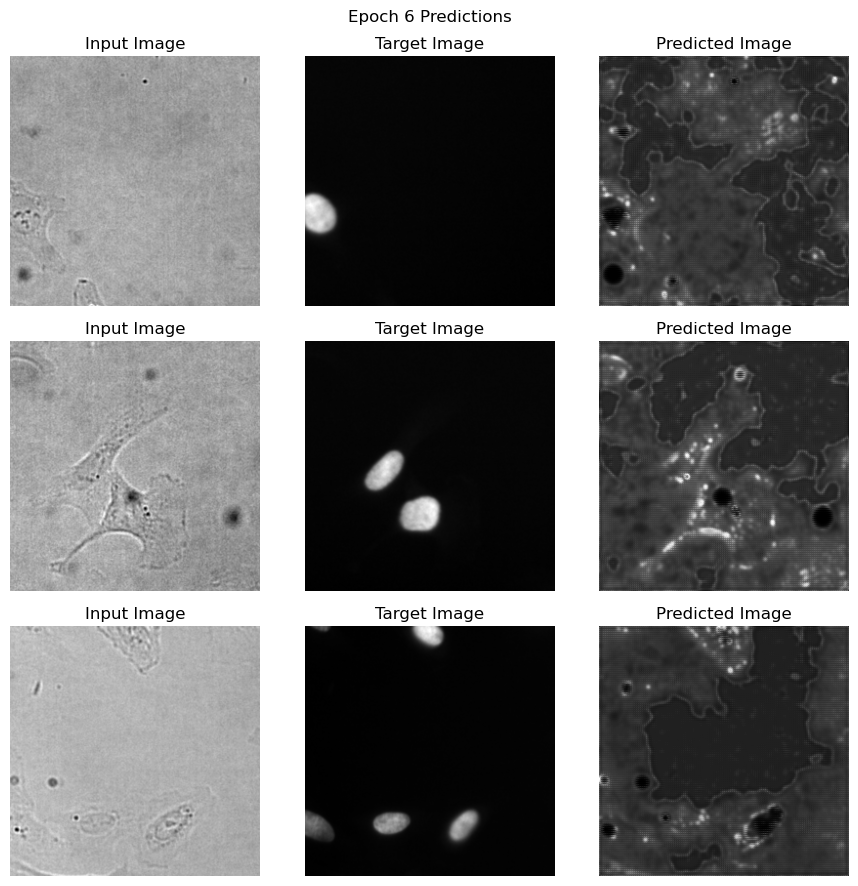

Epoch [7/10], Loss: 0.019835


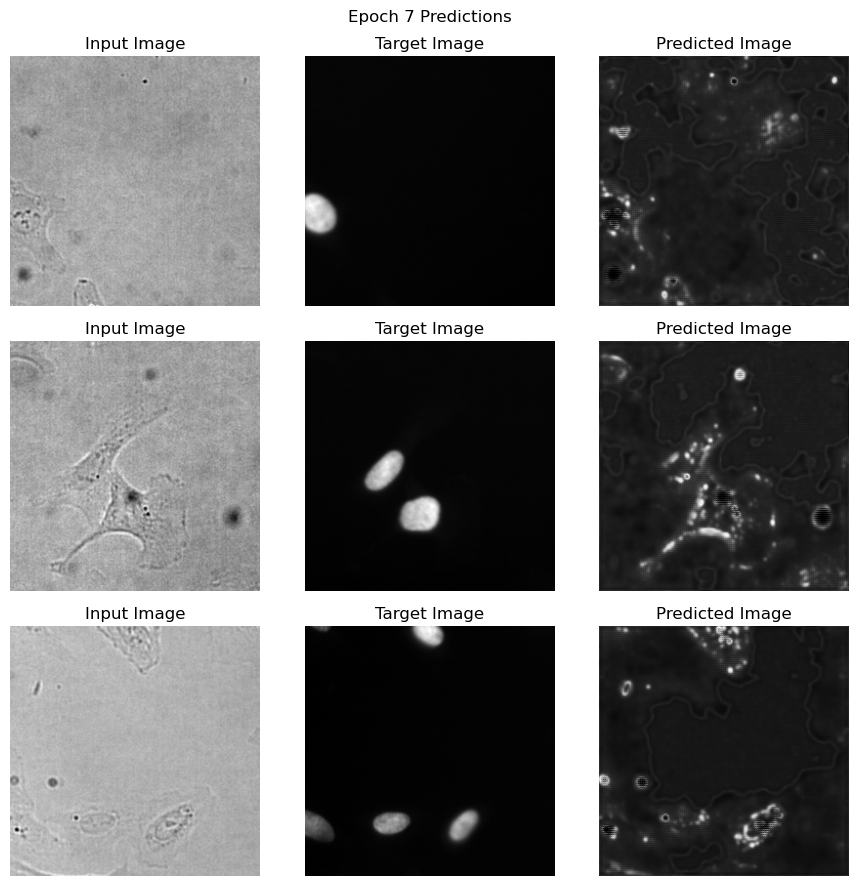

Epoch [8/10], Loss: 0.019443


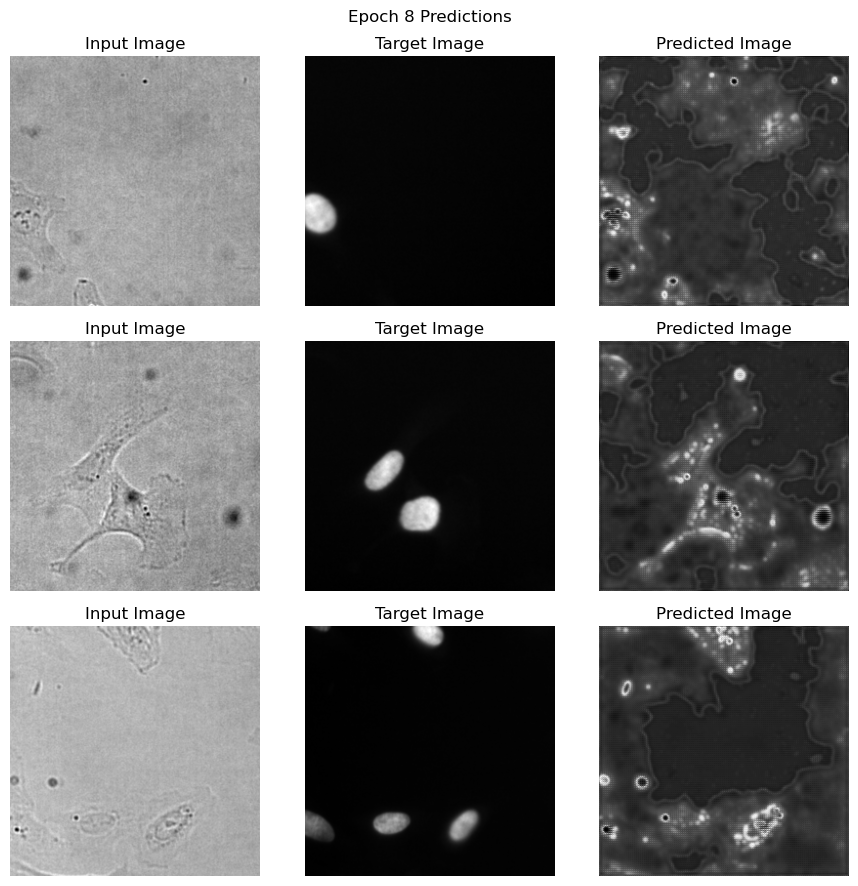

Epoch [9/10], Loss: 0.019183


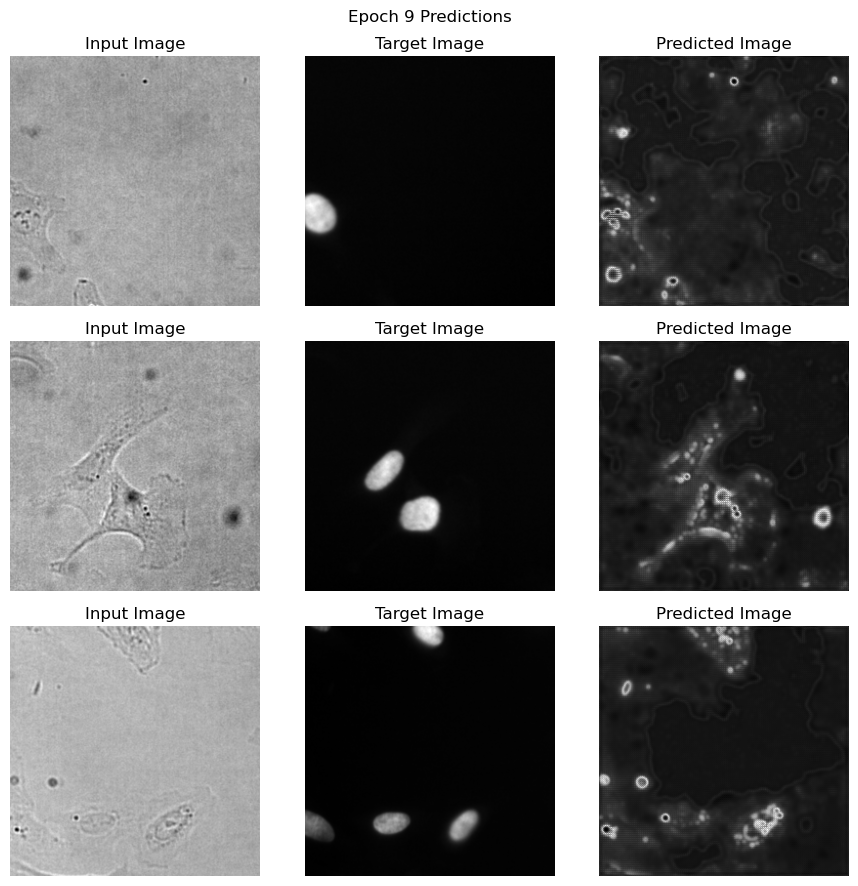

Epoch [10/10], Loss: 0.018859


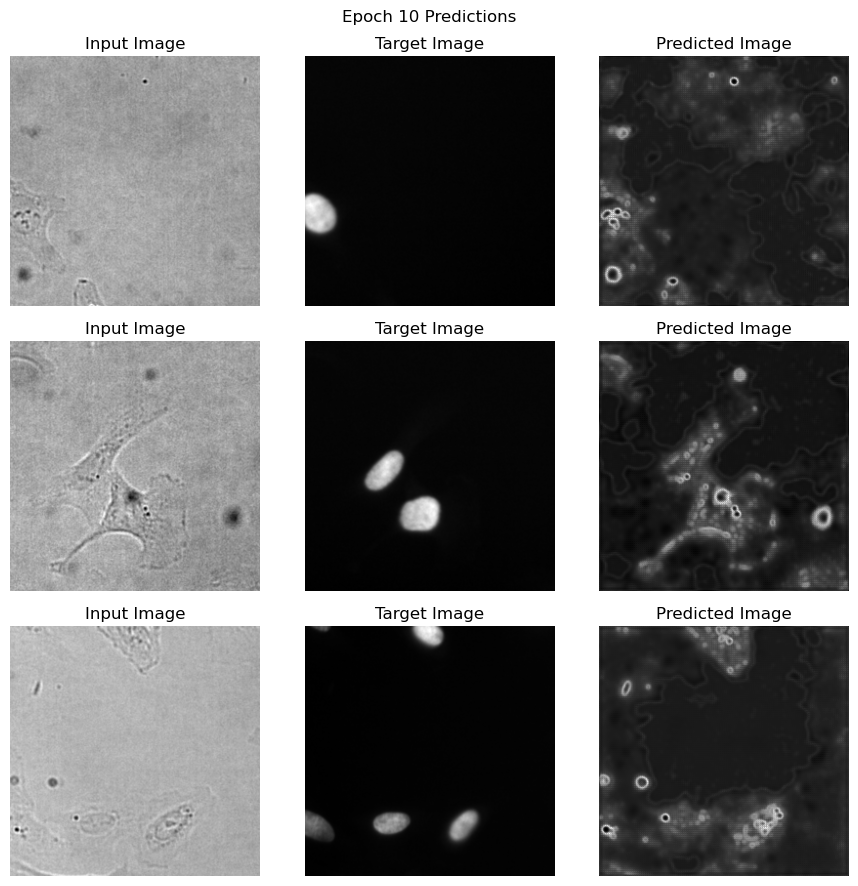

In [3]:
# Hyperparameters
batch_size = 8
epochs = 10
learning_rate = 0.005 # large learning rate for demo purposes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


panel_width = 3
indices = [3, 5, 7]

fully_conv_unet = UNet(
    in_channels=1,
    out_channels=1,
    depth=4,
    max_pool_down=False, # makes the model use Conv2DDownBlock
    act_type='sigmoid'
)

_ = fully_conv_unet.to(device)
train_loader = DataLoader(pds, batch_size=batch_size, shuffle=True)
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(fully_conv_unet.parameters(), lr=learning_rate)

for epoch in range(epochs):
    fully_conv_unet.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Move to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = fully_conv_unet(inputs)
        loss = loss_fn(outputs, targets)

        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")

    # plot some predictions
    fig, ax = plt.subplots(
        len(indices), 
        3, 
        figsize=(panel_width * 3, panel_width * len(indices)))

    for i, j in enumerate(indices):
        input, target = pds[j]
        pred = fully_conv_unet(input.unsqueeze(0).to(device))
        pred = pred.cpu().detach().numpy()
        ax[i][0].imshow(input[0], cmap='gray')
        ax[i][0].set_title('Input Image')
        ax[i][0].axis('off')
        ax[i][1].imshow(target[0], cmap='gray')
        ax[i][1].set_title('Target Image')
        ax[i][1].axis('off')
        ax[i][2].imshow(pred[0][0], cmap='gray')
        ax[i][2].set_title('Predicted Image')
        ax[i][2].axis('off')

    plt.suptitle(f'Epoch {epoch + 1} Predictions')
    plt.tight_layout()
    plt.show()